In [2]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
data = pd.read_pickle('df_exp1.pkl')
X = data.drop(columns=["N AufgewAmplitudeNom [MPa]"])
y = data["N AufgewAmplitudeNom [MPa]"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
def preprocess(X, X_train, X_test):
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OrdinalEncoder(), categorical_features)
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, preprocessor

In [5]:
def select_features_mi(X_train, y_train, X_test, k=15):
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected, selector

In [6]:
def select_features_rf(X_train, y_train, X_test, k):
    model = RandomForestRegressor(random_state=0, n_jobs=4)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[-k:]
    
    top_features = indices[::-1]
    
    X_train_selected = X_train[:, top_features]
    X_test_selected = X_test[:, top_features]
    
    return X_train_selected, X_test_selected, model

In [7]:
def plot_feature_importances(features, importances):
    f_i = list(zip(features, importances))
    f_i.sort(key = lambda x : x[1])
    f_i = f_i[-15:]
    plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
    plt.show()

In [8]:
X_train_processed, X_test_processed, preprocessor = preprocess(X, X_train, X_test)

In [9]:
X_train_mi, X_test_mi, selector = select_features_mi(X_train_processed, y_train, X_test_processed, k=15)

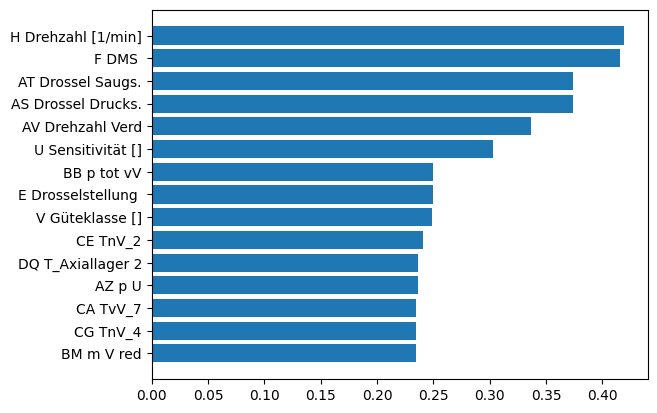

In [10]:
plot_feature_importances(X.columns, selector.scores_)

In [11]:
X_train_rf, X_test_rf, rf = select_features_rf(X_train_processed, y_train, X_test_processed, k=15)

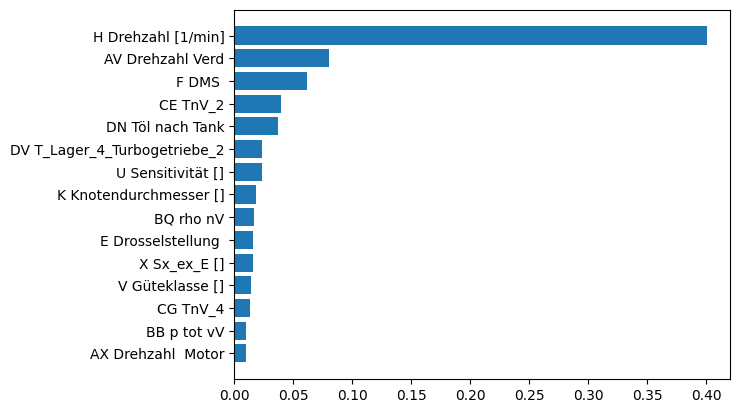

In [12]:
plot_feature_importances(X.columns, rf.feature_importances_)

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train_rf, y_train)
y_pred_lr_model = lr_model.predict(X_test_rf)
mse_lr_model = mean_squared_error(y_test, y_pred_lr_model)
print("Linear Regression MSE:", mse_lr_model)

Linear Regression MSE: 38.520288087760186


In [27]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train_rf, y_train)
y_pred_dt_model = dt_model.predict(X_test_rf)
mse_dt_model = mean_squared_error(y_test, y_pred_dt_model)

param_grid_dt_model = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_dt_model = GridSearchCV(dt_model, param_grid_dt_model, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid_search_dt_model.fit(X_train_rf, y_train)

best_dt_model = grid_search_dt_model.best_estimator_
y_pred_dt_model_hyper = best_dt_model.predict(X_test_rf)
mse_dt_model_hyper = mean_squared_error(y_test, y_pred_dt_model_hyper)
print("Decision Tree MSE:", mse_dt_model)
print("Hyperparameter Decision Tree MSE:", mse_dt_model_hyper)
print("Best Decision Tree Params:", grid_search_dt_model.best_params_)

Decision Tree MSE: 2.8572447975314876
Hyperparameter Decision Tree MSE: 2.8013584505492104
Best Decision Tree Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden)
        self.linear2 = nn.Linear(hidden, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [30]:
model = NeuralNetwork(15, 8, 1)

loss_module = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [31]:
X_train_tensor = torch.tensor(X_train_rf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_rf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
def train_model(model, optimizer, loss_module, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            loss.backward()
            optimizer.step()

In [34]:
def evaluate_model(model, test_loader, loss_module):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            total_loss += loss.item()
    
    average_loss = total_loss / len(test_loader)
    print(f"Test Loss: {average_loss}")
    return average_loss


In [35]:
train_model(model, optimizer, loss_module, train_loader, epochs=100)

/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [36]:
evaluate_model(model, test_loader, loss_module)

Test Loss: 41.472610570092236


/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


41.472610570092236

In [23]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
hidden = [4, 8, 16, 32]
hyperparameter_combinations = list(product(learning_rates, hidden))

In [25]:
best_loss = float('inf')
best_params = None
best_model = None

for lr, hidden, in hyperparameter_combinations:
    model = NeuralNetwork(input_size=15, hidden=hidden, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    print(f"Training with lr={lr}, hidden={hidden}")
    train_model(model, optimizer, loss_module, train_loader, epochs=50)
    test_loss = evaluate_model(model, test_loader, criterion)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = (lr, hidden)
        best_model = model

print(f"Best Loss: {best_loss}")
print(f"Best Params: Learning Rate={best_params[0]}, Hidden={best_params[1]}")


Training with lr=0.001, hidden=4
Test Loss: 41.44086421355036
Training with lr=0.001, hidden=8
Test Loss: 41.51419771536616
Training with lr=0.001, hidden=16
Test Loss: 41.44539283432123
Training with lr=0.001, hidden=32
Test Loss: 41.46382528770971
Training with lr=0.005, hidden=4
Test Loss: 41.47440674468761
Training with lr=0.005, hidden=8
Test Loss: 41.50143752571281
Training with lr=0.005, hidden=16
Test Loss: 41.58128841414706
Training with lr=0.005, hidden=32
Test Loss: 41.45265975071273
Training with lr=0.01, hidden=4
Test Loss: 41.44497933824554
Training with lr=0.01, hidden=8
Test Loss: 41.436308482221065
Training with lr=0.01, hidden=16
Test Loss: 41.44130635625533
Training with lr=0.01, hidden=32
Test Loss: 41.436861367626044
Training with lr=0.05, hidden=4
Test Loss: nan
Training with lr=0.05, hidden=8
Test Loss: nan
Training with lr=0.05, hidden=16
Test Loss: nan
Training with lr=0.05, hidden=32
Test Loss: nan
Training with lr=0.1, hidden=4
Test Loss: nan
Training with lr